In [26]:
%matplotlib inline

import sys
sys.path.append('/storage2/andrey/code/vrAnalysis/')

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as scipystats
from matplotlib.pyplot import figure

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES

In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
COLORS = get_colors()

#storage_path = '/home/andrey/storage2'
storage_path = '/storage2'

source = os.path.join(storage_path, 'andrey/data/processed')
assets = os.path.join(storage_path, 'andrey/data/projects/24_shift/assets')
paper =  os.path.join(storage_path, 'andrey/data/projects/24_shift/PAPER')
bad_clu_dir = os.path.join(storage_path, 'andrey/data/projects/24_shift/bad_clusters')

animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']

In [29]:
grps = {
    'b': [-0.1, 0.1],
    #'h': [0.1, 0.2], 
    'v': [0.1, 0.4]
}

In [30]:
def get_idxs_by_quality(dataset, sicA=0.2, pfrA=1.5, sicB=0.2, pfrB=1.5, iso=15):
    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sicA) & (dataset['sic_B'] > sicB)
    idxs_pfr = (dataset['peak_FR_A'] > pfrA) & (dataset['peak_FR_B'] > pfrB)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [31]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

In [32]:
def get_idxs_by_shift_range(dataset, shift_min, shift_max):
    return (dataset['shift'] > shift_min) & (dataset['shift'] < shift_max)

In [95]:
def plot_rate_metrics(metrics, titles, labels=None, colors=None, distances=None, plot_hist=True):
    clrs = [COLORS['a'] for x in range(len(metrics))] if colors is None else colors
    width = 2 if plot_hist else 1
    fig = plt.figure(figsize=(4*width, 4*len(metrics)))
    
    for i, (x_vals, y_vals) in enumerate(metrics):
        diffs = y_vals - x_vals
        slope, intercept, r_value, p_value, std_err = scipystats.linregress(x_vals, y_vals)
        st, pv = scipystats.kruskal(x_vals, y_vals)
        print("%s: %.5f" % (titles[i], pv))

        if distances is None:
            sizes = np.ones(len(x_vals))
        else:
            sizes = 50*distances[i]/distances[i].max()

        ax = fig.add_subplot(len(metrics), width, width*i+1)
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)
        ax.scatter(np.log(x_vals), np.log(y_vals), color=clrs[i], alpha=0.8, s=sizes)
        if i == len(metrics) - 1:
            ax.set_xlabel('Peak firing rate Light, log(Hz)', fontsize=14)
        ax.set_ylabel('Peak firing rate Dark, log(Hz)', fontsize=14)
        ax.plot([0, 3], [0, 3], ls='--', color=COLORS['b'])
        #ax.plot(np.log([1, 15]), np.log(intercept + slope*np.array([1, 15])), color=clrs[i])
        ax.set_title(titles[i], fontsize=14)
        ax.text(0.2, 2.3, 'n=%d\nsl=%.2f\n%s' % (len(y_vals), slope, labels[i]), fontsize=14)
        ax.grid()

        if plot_hist:
            ax = fig.add_subplot(len(metrics), width, width*i+2)
            bins = np.linspace(0, 5, 10)
            vals_l = ax.hist(diffs[diffs < 0], bins=bins - 5, color=clrs[i], ec='black')
            vals_h = ax.hist(diffs[diffs > 0], bins=bins, color=clrs[i], ec='black', alpha=0.5)
            ax.set_xlabel('Change in firing rate, Hz', fontsize=14)
            ax.set_ylabel('Number of fields', fontsize=14)
            ax.axvline(0.0, color=COLORS['b'], ls='--')
            ax.axvline(np.median(diffs), color=COLORS['b'])
            ax.set_xlim(-5, 5)
            ax.set_title('st=%.2f, p=%.4f' % (st, pv), fontsize=14)
        
            if labels:
                ax.text(2.5, np.array([vals_l[0].max(), vals_h[0].max()]).max() - 2, labels[i], fontsize=16)

    fig.tight_layout()
        
    return fig

# RATE REMAPPING - do not filter small rates!!!

## Rate remapping for cSHIFT

In [34]:
sessions_list = get_sessions_list(source, animals, 'SHIFT both +dark')

shift_A_B = get_fields_between_epochs(source, sessions_list, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, sessions_list, 'A', 'Ad')
shift_B_Ad = get_fields_between_epochs(source, sessions_list, 'B', 'Ad')
shift_B_Bd = get_fields_between_epochs(source, sessions_list, 'B', 'Bd')
shift_Ad_Bd = get_fields_between_epochs(source, sessions_list, 'Ad', 'Bd')

PF match found for 106 fields from total 194 A and 200 B fields
PF match found for 107 fields from total 194 A and 193 Ad fields
PF match found for 102 fields from total 200 B and 193 Ad fields
PF match found for 115 fields from total 200 B and 173 Bd fields
PF match found for 104 fields from total 193 Ad and 173 Bd fields


In [35]:
shift_A_B   = shift_A_B[get_idxs_of_good_clu(shift_A_B)]
shift_A_B   = shift_A_B[get_idxs_by_quality(shift_A_B)]
shift_A_Ad  = shift_A_Ad[get_idxs_of_good_clu(shift_A_Ad)]
shift_A_Ad  = shift_A_Ad[get_idxs_by_quality(shift_A_Ad)]
shift_B_Ad  = shift_B_Ad[get_idxs_of_good_clu(shift_B_Ad)]
shift_B_Ad  = shift_B_Ad[get_idxs_by_quality(shift_B_Ad)]
shift_B_Bd  = shift_B_Bd[get_idxs_of_good_clu(shift_B_Bd)]
shift_B_Bd  = shift_B_Bd[get_idxs_by_quality(shift_B_Bd)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_of_good_clu(shift_Ad_Bd)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_by_quality(shift_Ad_Bd)]

In [36]:
df_AB   = shift_A_B.add_prefix('ab_')
df_BAd  = shift_B_Ad.add_prefix('bad_')
df_AdBd = shift_Ad_Bd.add_prefix('adbd_')
df_AAd  = shift_A_Ad.add_prefix('aad_')
df_BBd  = shift_B_Bd.add_prefix('bbd_')

# OPTION 1 select stable fields via B-Ad
df_ABAd = df_AB.merge(df_BAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
       right_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_A'], how='inner')
df_ABAdBd = df_ABAd.merge(df_AdBd, left_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_B'], \
       right_on=['adbd_animal', 'adbd_session', 'adbd_electrode', 'adbd_unit', 'adbd_field_A'], how='inner')

#select interesting columns for firing rate analysis
rates = df_ABAdBd[['ab_peak_FR_A', 'ab_peak_FR_B', 'adbd_peak_FR_A', 'adbd_peak_FR_B', 'ab_shift']]
rates = rates.rename(columns={
   'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'adbd_peak_FR_A': 'peak_FR_Ad', \
   'adbd_peak_FR_B': 'peak_FR_Bd', 'ab_shift': 'shift'})


# # OPTION 2 select stable fields via A-Ad and B-Bd
# df_ABAd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
#         right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')
# df_ABAdBd = df_ABAd.merge(df_BBd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
#         right_on=['bbd_animal', 'bbd_session', 'bbd_electrode', 'bbd_unit', 'bbd_field_A'], how='inner')

# rates = df_ABAdBd[['ab_peak_FR_A', 'ab_peak_FR_B', 'aad_peak_FR_B', 'bbd_peak_FR_B', 'ab_shift']]
# rates = rates.rename(columns={
#     'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'aad_peak_FR_B': 'peak_FR_Ad', \
#     'bbd_peak_FR_B': 'peak_FR_Bd', 'ab_shift': 'shift'})

print('Found %s stable fields' % len(rates))

Found 39 stable fields


In [14]:
titles = [
    'A (light) - B (light)', 
    'A (light) - A (dark)', 
    'B (light) - B (dark)', 
    'Avg. light - Avg. dark'
]
labels = ['n.s.', '**', '**', '*']
metrics = [
    #(rates['peak_FR_A'], rates['peak_FR_B']),
    #(rates['peak_FR_A'], rates['peak_FR_Ad']),
    #(rates['peak_FR_B'], rates['peak_FR_Bd']),
    (shift_A_B['peak_FR_A'], shift_A_B['peak_FR_B']),
    (shift_A_Ad['peak_FR_A'], shift_A_Ad['peak_FR_B']),
    #(shift_B_Bd['peak_FR_A'], shift_B_Bd['peak_FR_B']),
    #((rates['peak_FR_A'] + rates['peak_FR_B']) / 2, (rates['peak_FR_Ad'] + rates['peak_FR_Bd']) / 2)
]

fig = plot_rate_metrics(metrics, titles, labels)

filename = "E_2e.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### Rate remapping for pSHIFT

In [37]:
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']

s_list_periodic_dark = get_sessions_list(source, animals, 'SHIFT periodic +dark')
s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
s_list_with_dark = list(s_list_single) + list(s_list_periodic_dark)

len(s_list_with_dark)

52

In [38]:
shift_A_B = get_fields_between_epochs(source, s_list_with_dark, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Ad')
shift_B_Bd = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Bd')
shift_Ad_Bd = get_fields_between_epochs(source, s_list_with_dark, 'Ad', 'Bd')
shift_A_Bd = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Bd')
shift_B_Ad = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Ad')

No required H5 file found for 2020-10-23_12-57-03
PF match found for 796 fields from total 1553 A and 1551 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 717 fields from total 1491 A and 1549 Ad fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 725 fields from total 1469 B and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 685 fields from total 1530 Ad and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 637 fields from total 1474 A and 1441 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 706 fields from total 1484 B and 1545 Ad fields


In [39]:
shift_A_B   = shift_A_B[get_idxs_of_good_clu(shift_A_B)]
shift_A_B   = shift_A_B[get_idxs_by_quality(shift_A_B)]
shift_A_Ad  = shift_A_Ad[get_idxs_of_good_clu(shift_A_Ad)]
shift_A_Ad  = shift_A_Ad[get_idxs_by_quality(shift_A_Ad, pfrB=0.1)]
shift_B_Ad  = shift_B_Ad[get_idxs_of_good_clu(shift_B_Ad)]
shift_B_Ad  = shift_B_Ad[get_idxs_by_quality(shift_B_Ad, pfrB=0.1)]
shift_B_Bd  = shift_B_Bd[get_idxs_of_good_clu(shift_B_Bd)]
shift_B_Bd  = shift_B_Bd[get_idxs_by_quality(shift_B_Bd, pfrB=0.1)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_of_good_clu(shift_Ad_Bd)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_by_quality(shift_Ad_Bd, pfrA=0.1, pfrB=0.1)]

In [54]:
df_AB   = shift_A_B.add_prefix('ab_')
df_BAd  = shift_B_Ad.add_prefix('bad_')
df_AdBd = shift_Ad_Bd.add_prefix('adbd_')
df_AAd  = shift_A_Ad.add_prefix('aad_')
df_BBd  = shift_B_Bd.add_prefix('bbd_')

# OPTION 1 select stable fields via B-Ad
df_ABBd = df_AB.merge(df_BAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_A'], how='inner')
df_ABAdBd = df_ABBd.merge(df_AdBd, left_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_B'], \
        right_on=['adbd_animal', 'adbd_session', 'adbd_electrode', 'adbd_unit', 'adbd_field_A'], how='inner')

# OPTION 2 filter above by merging with A-Ad
df_f3 = df_ABAdBd.merge(df_AAd, \
   left_on =['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A', 'bad_field_B'], \
   right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A', 'aad_field_B'], how='inner')

# OPTION 3 filter above by merging with B-Bd
df_f4 = df_f3.merge(df_BBd, \
   left_on =['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B', 'adbd_field_B'], \
   right_on=['bbd_animal', 'bbd_session', 'bbd_electrode', 'bbd_unit', 'bbd_field_A', 'bbd_field_B'], how='inner')


# OPTION 4 select stable fields via A-Ad
df_ABAd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')


# select interesting columns for shift analysis
stable = df_f4[['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_shift', 'adbd_shift']]

# select interesting columns for firing rate analysis
rates = df_ABAdBd[['ab_peak_FR_A', 'ab_peak_FR_B', 'adbd_peak_FR_A', 'adbd_peak_FR_B', 'ab_shift', 'ab_COMa_y']]
rates = rates.rename(columns={
    'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'adbd_peak_FR_A': 'peak_FR_Ad', \
    'adbd_peak_FR_B': 'peak_FR_Bd', 'ab_shift': 'shift', 'ab_COMa_y': 'COMa_y'})

print('Found %s stable fields' % len(stable))

Found 237 stable fields


### change in firing rate between conditions

In [33]:
titles = [
    'A (light) - B (light)', 
    'A (light) - A (dark)', 
    #'B (light) - B (dark)', 
    #'light - dark'
]
labels = ['n.s.', '**']
metrics = [
    (rates['peak_FR_A'], rates['peak_FR_B']),
    (rates['peak_FR_A'], rates['peak_FR_Ad']),
    #(rates['peak_FR_B'], rates['peak_FR_Bd']),
    #((rates['peak_FR_A'] + rates['peak_FR_B']) / 2, (rates['peak_FR_Ad'] + rates['peak_FR_Bd']) / 2)
]

fig = plot_rate_metrics(metrics, titles, labels=labels)

### change in firing rate between groups of cells

In [68]:
#shift_A_B['COMa_y'].min(), shift_A_B['COMa_y'].max()
d1 = np.array(rates['COMa_y']) + 0.9
d2 = 0.7 - np.array(rates['COMa_y'])

d_min = np.min(np.column_stack([d1, d2]), axis=1)[:5]
d_min.min(), d_min.max()

(0.02958649403347202, 0.7009256250145621)

In [67]:
d1[:5], d2[:5]

(array([1.03236463, 1.12678132, 0.02958649, 0.38779454, 0.70092563]),
 array([0.56763537, 0.47321868, 1.57041351, 1.21220546, 0.89907437]))

Boundary: 0.67265
Visual: 0.00000


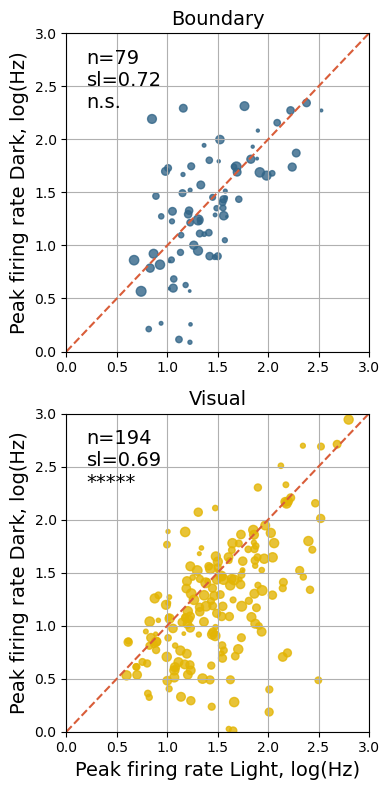

In [97]:
df = rates.copy()

# correct for diff ref frame
df['shift'] = (-1) * (df['shift'] - 0.3)

PFRs_0 = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['b'][1])]
#PFRs_15 = df[(df['shift'] > grps['h'][0]) & (df['shift'] < grps['h'][1])]
PFRs_30 = df[(df['shift'] > grps['v'][0]) & (df['shift'] < grps['v'][1])]

# PFRs_0  = df[(df['shift'] > -0.075) & (df['shift'] < 0.075)]
# PFRs_15 = df[(df['shift'] > 0.075) & (df['shift'] < 0.225)]
# PFRs_30 = df[(df['shift'] > 0.225) & (df['shift'] < 0.375)]

# compute distance to the nearest wall
def get_dist(COMa_ys):
    return np.min(np.column_stack([COMa_ys + 0.9, 0.7 - COMa_ys]), axis=1)

titles = ['Boundary', 'Visual']  # 'Hybrid', 
colors = [COLORS['a'], COLORS['d']]  # COLORS['c'], 
labels = ['n.s.', '*****']  # '***',
distances = [
    get_dist(np.array(PFRs_0['COMa_y'])),
    get_dist(np.array(PFRs_30['COMa_y'])),
]
metrics = [
    ((PFRs_0['peak_FR_A'] + PFRs_0['peak_FR_B'])/2, (PFRs_0['peak_FR_Ad'] + PFRs_0['peak_FR_Bd'])/2),
    #((PFRs_15['peak_FR_A'] + PFRs_15['peak_FR_B'])/2, (PFRs_15['peak_FR_Ad'] + PFRs_15['peak_FR_Bd'])/2),
    ((PFRs_30['peak_FR_A'] + PFRs_30['peak_FR_B'])/2, (PFRs_30['peak_FR_Ad'] + PFRs_30['peak_FR_Bd'])/2)
    #(PFRs_0['peak_FR_A'], PFRs_0['peak_FR_Ad']),
    #(PFRs_15['peak_FR_A'], PFRs_15['peak_FR_Ad']),
    #(PFRs_30['peak_FR_A'], PFRs_30['peak_FR_Ad']),
    
]

fig = plot_rate_metrics(metrics, titles, labels, colors, distances, plot_hist=False)
fig.tight_layout()
filename = "2f.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

In [103]:
# same for distance
df = rates.copy()

# correct for diff ref frame
df['shift'] = (-1) * (df['shift'] - 0.3)

PFRs_0 = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['b'][1])]
PFRs_30 = df[(df['shift'] > grps['v'][0]) & (df['shift'] < grps['v'][1])]

# compute distance to the nearest wall
def get_dist(COMa_ys):
    return np.min(np.column_stack([COMa_ys + 0.9, 0.7 - COMa_ys]), axis=1)

titles = ['Boundary', 'Visual']  # 'Hybrid', 
colors = [COLORS['a'], COLORS['d']]  # COLORS['c'], 
labels = ['n.s.', '*****']  # '***',
distances = [
    get_dist(np.array(PFRs_0['COMa_y'])),
    get_dist(np.array(PFRs_30['COMa_y'])),
]
avgs = {
    'avg_b_l': (PFRs_0['peak_FR_A'] + PFRs_0['peak_FR_B'])/2,
    'avg_b_d': (PFRs_0['peak_FR_Ad'] + PFRs_0['peak_FR_Bd'])/2,
    'avg_v_l': (PFRs_30['peak_FR_A'] + PFRs_30['peak_FR_B'])/2,
    'avg_v_d': (PFRs_30['peak_FR_Ad'] + PFRs_30['peak_FR_Bd'])/2
}
metrics = [
    (distances[0], (avgs['avg_b_l'] - avgs['avg_b_d'])/(avgs['avg_b_l'] + avgs['avg_b_d'])),
    (distances[1], (avgs['avg_v_l'] - avgs['avg_v_d'])/(avgs['avg_v_l'] + avgs['avg_v_d']))
]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, metric in enumerate(metrics):
    axes[i].scatter(metrics[i][0], metrics[i][1], color=colors[i])
    axes[i].grid()
    axes[i].set_ylim(-0.6, 0.9)


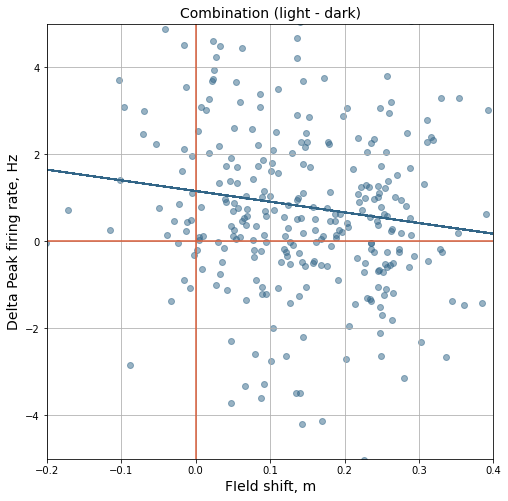

In [224]:

#plt.scatter(df_ABAd['ab_shift'], df_ABAd['ab_peak_FR_A'] - df_ABAd['aad_peak_FR_B'])

x_vals = df_ABAd['ab_shift']
y_vals = df_ABAd['ab_peak_FR_A'] - df_ABAd['aad_peak_FR_B']


fig = plt.figure(figsize=(8, 8))

slope, intercept, r_value, p_value, std_err = scipystats.linregress(x_vals, y_vals)
st, pv = scipystats.kruskal(x_vals, y_vals)

ax = fig.add_subplot(111)
ax.set_xlim(-0.2, 0.4)
ax.set_ylim(-5, 5)
ax.axvline(0, color=COLORS['b'])
ax.axhline(0, color=COLORS['b'])
#ax.set_aspect('equal')
ax.scatter(x_vals, y_vals, color=COLORS['a'], alpha=0.5)
ax.set_xlabel('FIeld shift, m', fontsize=14)
ax.set_ylabel('Delta Peak firing rate, Hz', fontsize=14)
#ax.plot([0, 15], [0, 15], ls='--', color=COLORS['b'])
ax.plot(x_vals, intercept + slope*x_vals, color=COLORS['a'])
ax.set_title(titles[i], fontsize=14)
#ax.text(2.5, 12.2, 'n=%d\nsl=%.2f' % (len(y_vals), slope), fontsize=14)
ax.grid()

In [221]:
st, pv

(22.082584675163957, 2.6116842631744965e-06)

### Rate remapping for vSHIFT

In [31]:
animals = ['00908', '00910', '002784', '003281', '003282', '003909', '005363', '005364']

#s_list_l = get_sessions_list(source, animals, 'SHIFT visual')
s_list_s = get_sessions_list(source, animals, 'SHIFT visual +dark')
s_list_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')
#s_list_all = list(s_list_l) + list(s_list_d)

data = {}
for cond_A, cond_B in [('A', 'B'), ('A', 'D'), ('B', 'D')]:
    for i, sessions in enumerate([s_list_s, s_list_l]):
        ds = get_fields_between_epochs(source, sessions, cond_A, cond_B)
        pfrB = 0.1 if cond_B == 'D' else 1.5
        data['%s%s_%s' % (cond_A, cond_B, 's' if i==0 else 'l')] = ds[get_idxs_by_quality(ds, pfrB=pfrB)]

print('Found %s sessions' % len(s_list_s))

PF match found for 155 fields from total 276 A and 288 B fields
PF match found for 288 fields from total 516 A and 527 B fields
PF match found for 145 fields from total 276 A and 254 D fields
PF match found for 289 fields from total 516 A and 524 D fields
PF match found for 151 fields from total 288 B and 254 D fields
PF match found for 275 fields from total 527 B and 524 D fields
Found 7 sessions


In [38]:
df_ABs = data['AB_s'].add_prefix('ab_')
df_BDs = data['BD_s'].add_prefix('bd_')
df_ADs = data['AD_s'].add_prefix('ad_')
df_ABl = data['AB_l'].add_prefix('ab_')
df_BDl = data['BD_l'].add_prefix('bd_')
df_ADl = data['AD_l'].add_prefix('ad_')

# OPTION 1 select stable fields via A-D
df_ABDs = df_ABs.merge(df_ADs, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')
df_ABDl = df_ABl.merge(df_ADl, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')

# select interesting columns for firing rate analysis
rates = df_ABDs[['ab_peak_FR_A', 'ab_peak_FR_B', 'ad_peak_FR_B', 'ab_shift']]
rates = rates.rename(columns={
    'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'ad_peak_FR_B': 'peak_FR_D', 'ab_shift': 'shift'})
print('Found %s fields' % len(rates))

Found 60 fields


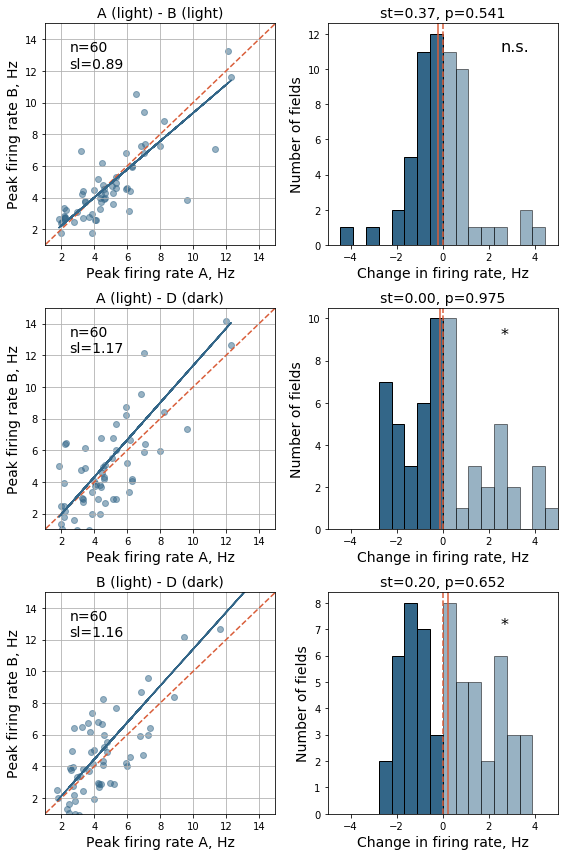

In [39]:
titles = [
    'A (light) - B (light)', 
    'A (light) - D (dark)', 
    'B (light) - D (dark)', 
    'light - dark'
]
labels = ['n.s.', '*', '*', '*']
metrics = [
    (rates['peak_FR_A'], rates['peak_FR_B']),
    (rates['peak_FR_A'], rates['peak_FR_D']),
    (rates['peak_FR_B'], rates['peak_FR_D']),
    #(shift_A_B['peak_FR_A'], shift_A_B['peak_FR_B']),
    #(shift_A_D['peak_FR_A'], shift_A_D['peak_FR_B']),
    #(shift_B_D['peak_FR_A'], shift_B_D['peak_FR_B']),    
    #((rates['peak_FR_A'] + rates['peak_FR_B']) / 2, rates['peak_FR_D'])
]

fig = plot_rate_metrics(metrics, titles, labels=labels)

In [41]:
df = rates.copy()

PFRs_0  = df[(df['shift'] > -0.375) & (df['shift'] < -0.225)]
PFRs_15 = df[(df['shift'] > -0.225) & (df['shift'] < -0.075)]
PFRs_30 = df[(df['shift'] > -0.075) & (df['shift'] < 0.075)]

titles = ['Visual (light - dark)', 'Combination (light - dark)', 'Self-motion (light - dark)']
colors = [COLORS['d'], COLORS['c'], COLORS['a']]
labels = ['**', '*', 'n.s.']
metrics = [
    #((PFRs_0['peak_FR_A'] + PFRs_0['peak_FR_B'])/2, PFRs_0['peak_FR_D']),
    #((PFRs_15['peak_FR_A'] + PFRs_15['peak_FR_B'])/2, PFRs_15['peak_FR_D']),
    #((PFRs_30['peak_FR_A'] + PFRs_30['peak_FR_B'])/2, PFRs_30['peak_FR_D'])
    (PFRs_0['peak_FR_A'], PFRs_0['peak_FR_D']),
    (PFRs_15['peak_FR_A'], PFRs_15['peak_FR_D']),
    (PFRs_30['peak_FR_A'], PFRs_30['peak_FR_D'])    
]

fig = plot_rate_metrics(metrics, titles, labels, colors)

### GAIN

In [28]:
animals = ['003908', '003909', '005363', '005364']  # last four, add '003908', '003909'

sessions_12 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.2x'))
sessions_14 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.4x'))

data = {}
for cond_A, cond_B in [('A', 'B'), ('A', 'C'), ('C', 'D'), ('A', 'D')]:  # look for full / rate remapping in 14 A, C -> D
    for i, sessions in enumerate([sessions_12, sessions_14]):
        ds = get_fields_between_epochs(source, sessions, cond_A, cond_B)
        data['%s%s_%d' % (cond_A, cond_B, 12 + i*2)] = ds[get_idxs_by_quality(ds)]

PF match found for 574 fields from total 1080 A and 1030 B fields
PF match found for 341 fields from total 657 A and 623 B fields
PF match found for 523 fields from total 1080 A and 1010 C fields
PF match found for 314 fields from total 657 A and 624 C fields
PF match found for 543 fields from total 1006 C and 1018 D fields
PF match found for 320 fields from total 574 C and 548 D fields
PF match found for 491 fields from total 1078 A and 1018 D fields
PF match found for 261 fields from total 602 A and 548 D fields


In [29]:
for key, val in data.items():
    print(key, len(val))

('AD_14', 169)
('AC_12', 327)
('AC_14', 214)
('AB_12', 367)
('CD_14', 227)
('CD_12', 336)
('AD_12', 285)
('AB_14', 241)


In [30]:
#data['AC_14'][(data['AC_14']['shift'] > -0.7) & (data['AC_14']['shift'] < 0.075)]

In [31]:
lonely = {}
for cond_A, cond_B in [('A', 'B'), ('A', 'C'), ('C', 'D'), ('A', 'D')]:  # look for full / rate remapping in 14 A, C -> D
    for i, sessions in enumerate([sessions_12, sessions_14]):
        lnl = pd.concat([get_lonely_fields(source, rec[0], rec[1], cond_A, cond_B) for rec in sessions])
        lnl = lnl[lnl['cond'] == cond_A]
        lnl = lnl[(lnl['sic'] > 0.15) & (lnl['isol_dist'] > 20) & (lnl['peak_FR'] > 1.5)]
        lonely['%s%s_%d' % (cond_A, cond_B, 12 + i*2)] = lnl

In [32]:
for key, val in lonely.items():
    print(key, len(val))

('AD_14', 81)
('AC_12', 126)
('AC_14', 76)
('AB_12', 98)
('CD_14', 41)
('CD_12', 104)
('AD_12', 149)
('AB_14', 64)


In [21]:
len(lonely['AB_14'][lonely['AB_14']['COMa_y'] < 0]), len(lonely['AB_14'][lonely['AB_14']['COMa_y'] > 0.3])

(66, 55)

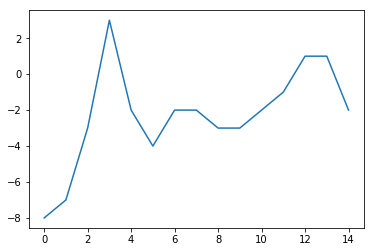

In [40]:
bins = np.linspace(-0.8, 0.8, 16)
b1, edges = np.histogram(lonely['AB_12']['COMa_y'], bins)
b2, edges = np.histogram(lonely['AB_14']['COMa_y'], bins)
plt.plot(b2 - b1)


In [37]:
b1, b2

(array([ 2,  6,  5,  6,  3,  3,  2,  1,  2,  6,  5,  5,  3, 10,  5]),
 array([ 2,  6,  5,  6,  3,  3,  2,  1,  2,  6,  5,  5,  3, 10,  5]))

In [25]:
titles = [
    'A (light) - B (light)', 
    'A (light) - D (dark)', 
    'B (light) - D (dark)', 
    'light - dark'
]
labels = ['n.s.', '*', '*', '*']
metrics = [
    (data['AB_14']['peak_FR_A'], data['AB_14']['peak_FR_B']),
    (data['AC_14']['peak_FR_A'], data['AC_14']['peak_FR_B']),
    (data['CD_14']['peak_FR_A'], data['CD_14']['peak_FR_B']),
    (data['AD_14']['peak_FR_A'], data['AD_14']['peak_FR_B']),
#     (data['AB_12']['peak_FR_A'], data['AB_12']['peak_FR_B']),
#     (data['AB_12']['peak_FR_A'], data['AB_12']['peak_FR_B']),
#     (data['AB_12']['peak_FR_A'], data['AB_12']['peak_FR_B']),
#     (data['AB_12']['peak_FR_A'], data['AB_12']['peak_FR_B']),
]

fig = plot_rate_metrics(metrics, titles) #, labels=labels)

In [41]:
df_AB_12 = data['AB_12'].add_prefix('ab_')
df_AD_12 = data['AB_12'].add_prefix('ad_')
df_AB_14 = data['AB_14'].add_prefix('ab_')
df_AD_14 = data['AB_14'].add_prefix('ad_')

# OPTION 1 select stable fields via B-D
df_ABD_12 = df_AB_12.merge(df_AD_12, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')
df_ABD_14 = df_AB_14.merge(df_AD_14, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['ad_animal', 'ad_session', 'ad_electrode', 'ad_unit', 'ad_field_A'], how='inner')

In [44]:
df_0 = df_ABD_12[(df_ABD_12['ab_shift'] > -0.375) & (df_ABD_12['ab_shift'] < -0.225)]
df_15 = df_ABD_12[(df_ABD_12['ab_shift'] > -0.225) & (df_ABD_12['ab_shift'] < -0.075)]
df_30 = df_ABD_12[(df_ABD_12['ab_shift'] > -0.075) & (df_ABD_12['ab_shift'] < 0.075)]

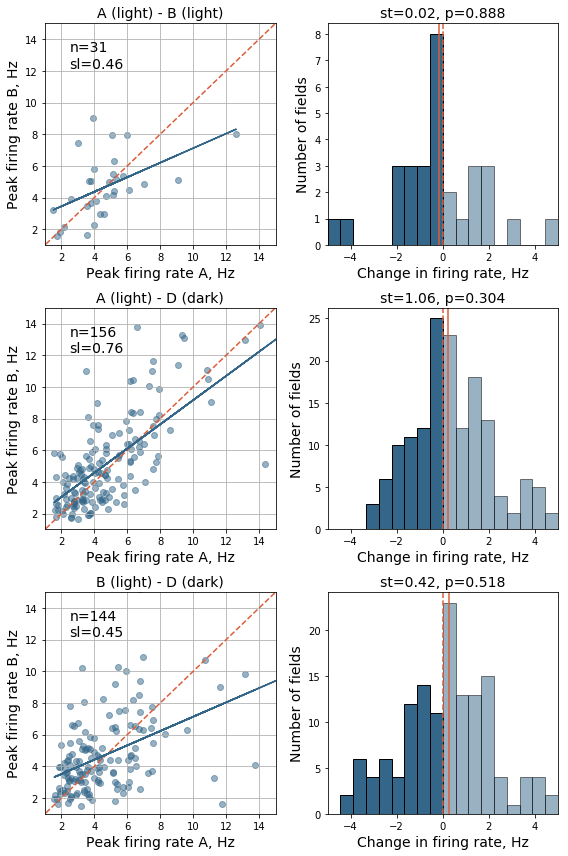

In [45]:
titles = [
    'A (light) - B (light)', 
    'A (light) - D (dark)', 
    'B (light) - D (dark)', 
    'light - dark'
]
labels = ['n.s.', '*', '*', '*']
metrics = [
    (df_0['ab_peak_FR_A'], df_0['ad_peak_FR_B']),
    (df_15['ab_peak_FR_A'], df_15['ad_peak_FR_B']),
    (df_30['ab_peak_FR_A'], df_30['ad_peak_FR_B']),
]

fig = plot_rate_metrics(metrics, titles) #, labels=labels)